# **安裝套件**

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# **資料集路徑**

In [2]:
train_dir = '/kaggle/input/plant-disease-recognition-dataset/Train/Train'
test_dir = '/kaggle/input/plant-disease-recognition-dataset/Test/Test'
val_dir = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation'

# **數據增強**

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# **動態生成訓練數據**

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1322 images belonging to 3 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 60 images belonging to 3 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 150 images belonging to 3 classes.


In [7]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['Healthy', 'Powdery', 'Rust']


In [8]:
def show_images_for_class(class_name, directory, num_images=5):
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        img = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

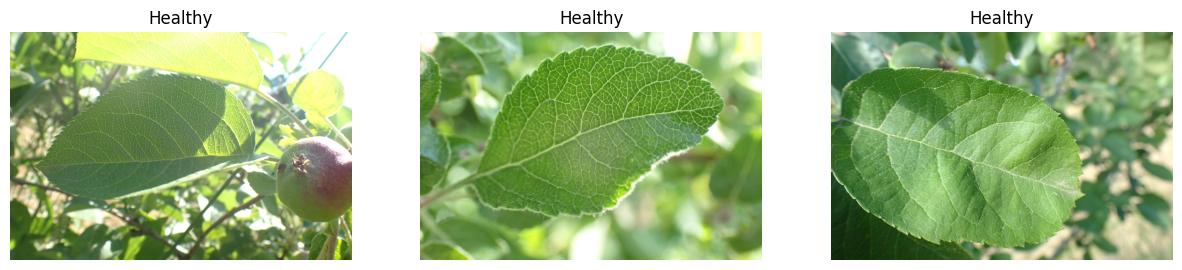

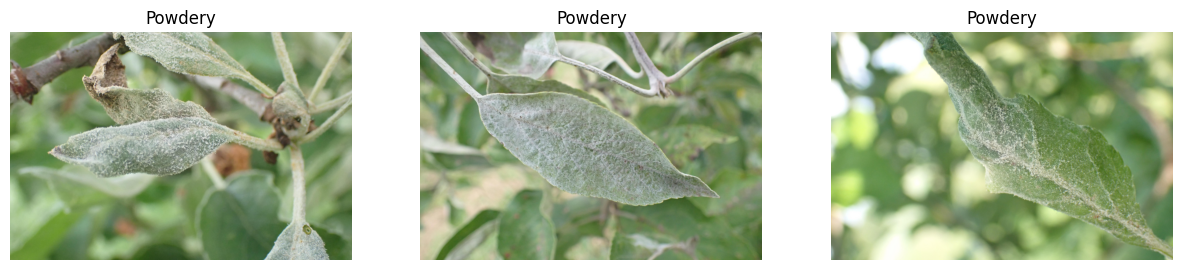

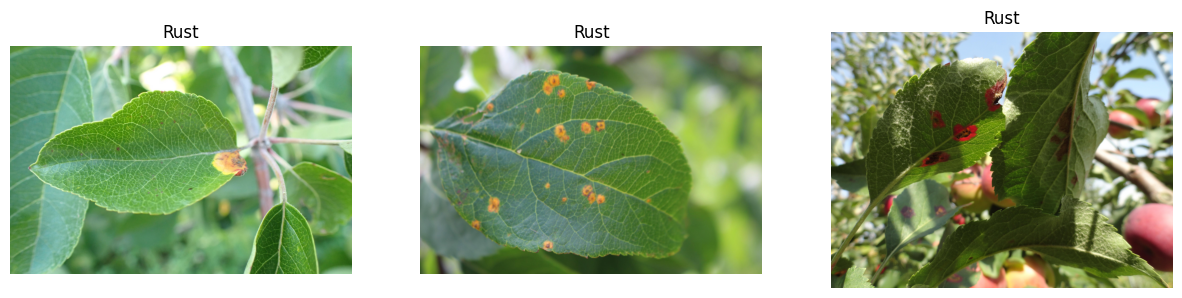

In [9]:
for class_name in class_names:
    show_images_for_class(class_name, train_dir, num_images=3)

Healthy : Refers to healthy plants. Plants in this class do not show any signs of disease, and the leaves/overall plant tissue appear healthy.

Powdery : A fungal disease characterized by a white or gray powder-like appearance on the leaves. The fungal spores accumulate on the leaf surface, reducing the plant's ability to photosynthesize and leading to weak growth.

Rust : A fungal disease that causes orange, red, or brown rust-like spots on the leaves. This negatively affects the plant's health and is caused by a fungal infection.

# CNN MODEL

In [10]:
model = Sequential([

    Input(shape=(224, 224, 3)),
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(3, activation='softmax')
])

In [11]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,536,675 (36.38 MB)

 Trainable params: 9,536,675 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734053178.208889      89 service.cc:145] XLA service 0x7fbdf000c340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734053178.208943      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/42 ━━━━━━━━━━━━━━━━━━━━ 18:02 26s/step - accuracy: 0.2188 - loss: 1.1026

I0000 00:00:1734053184.540169      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3934 - loss: 1.1490 - val_accuracy: 0.7000 - val_loss: 0.7209
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7243 - loss: 0.6347 - val_accuracy: 0.8167 - val_loss: 0.3917
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8716 - loss: 0.4083 - val_accuracy: 0.8500 - val_loss: 0.4108
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8801 - loss: 0.3533 - val_accuracy: 0.8000 - val_loss: 0.4507
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8862 - loss: 0.3619 - val_accuracy: 0.9333 - val_loss: 0.2672
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9053 - loss: 0.3020 - val_accuracy: 0.9333 - val_loss: 0.1900
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9206 - loss: 0.2428 - val_accuracy: 0.9500 - val_loss: 0.1769
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9254 - loss: 0.1988 - val_accuracy: 0.9167 - val_loss: 0.2867
Ep

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9549 - loss: 0.1918
Test Loss: 0.21045462787151337, Test Accuracy: 0.95333331823349


In [15]:
def plot_training(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    start_epoch = history.epoch[0]
    epochs_range = range(start_epoch, start_epoch + len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs_range[::2])
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs_range[::2])
    
    plt.show()

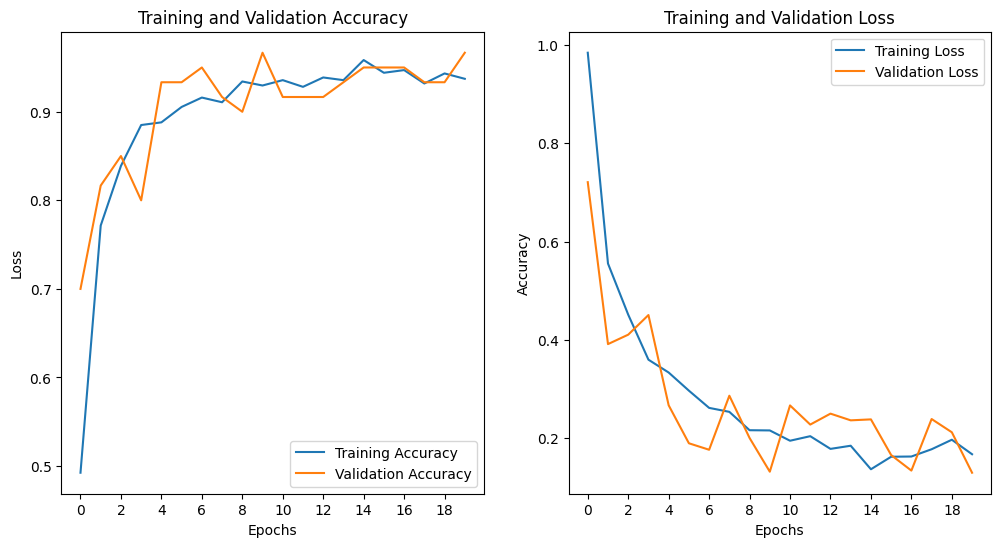

In [16]:
plot_training(history)

In [17]:
def evaluate_model(model, test_generator):
    
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)  
    y_true = test_generator.classes           

    class_labels = list(test_generator.class_indices.keys())

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Classification Report:

              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.93        50
     Powdery       1.00      0.88      0.94        50
        Rust       1.00      0.98      0.99        50

    accuracy                           0.95       150
   macro avg       0.96      0.95      0.95       150
weighted avg       0.96      0.95      0.95       150



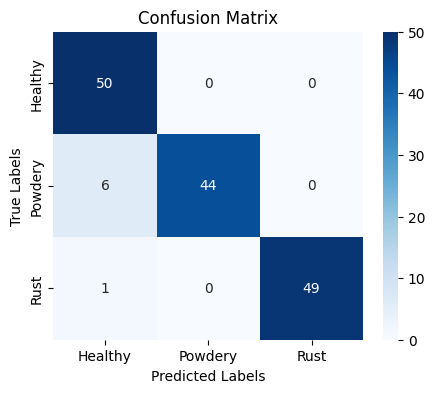

In [18]:
evaluate_model(model, test_generator)

# TRANSFER LEARNING

VGG16

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=output_layer)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
vgg_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
vgg_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
initial_epochs = 10
history_transfer = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=initial_epochs,
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4391 - loss: 3.2378 - val_accuracy: 0.8667 - val_loss: 0.4587
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7416 - loss: 0.6487 - val_accuracy: 0.9000 - val_loss: 0.3482
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7829 - loss: 0.5686 - val_accuracy: 0.7667 - val_loss: 0.4446
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7876 - loss: 0.5059 - val_accuracy: 0.9833 - val_loss: 0.2608
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8240 - loss: 0.4390 - val_accuracy: 0.9333 - val_loss: 0.2510
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8209 - loss: 0.4495 - val_accuracy: 0.9333 - val_loss: 0.2173
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8299 - loss: 0.4472 - val_accuracy: 0.8833 - val_loss: 0.2095
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8658 - loss: 0.3895 - val_accuracy: 0.9667 - val_loss

In [23]:
test_loss, test_accuracy = vgg_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.9199 - loss: 0.3212

2024-12-13 02:10:40.676300: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[22,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,256,56,56]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-13 02:10:40.676482: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.000293481s
Trying algorithm eng12{k11=2} for conv (f32[22,256,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,256,56,56]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_qu

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9066 - loss: 0.3473
Test Loss: 0.39939191937446594, Test Accuracy: 0.8799999952316284


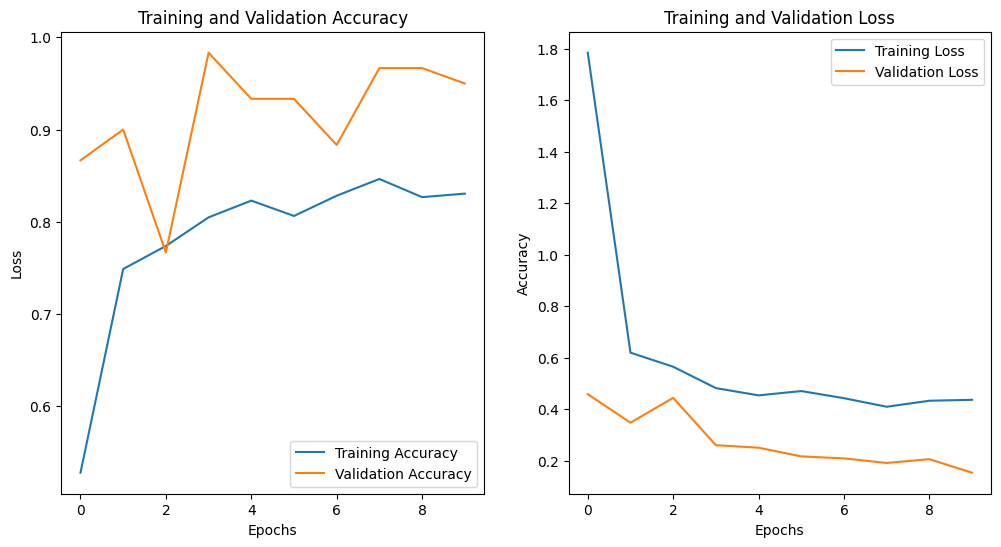

In [24]:
plot_training(history_transfer)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Classification Report:

              precision    recall  f1-score   support

     Healthy       0.80      0.96      0.87        50
     Powdery       0.95      0.82      0.88        50
        Rust       0.91      0.86      0.89        50

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



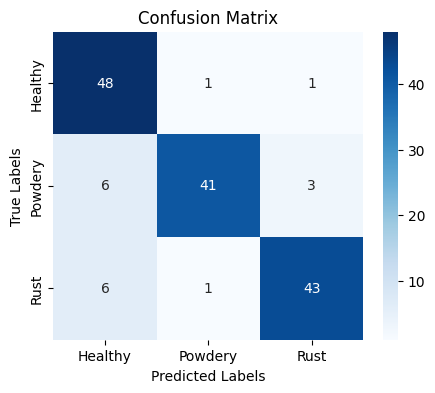

In [25]:
evaluate_model(vgg_model, test_generator)

In [26]:
# Fine-Tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True


vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5), # 0.00001 learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

finetune_epochs = 10
total_epochs = initial_epochs + finetune_epochs

# Fine-Tuning Training
history_finetune = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=initial_epochs
)

Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8481 - loss: 0.4033 - val_accuracy: 0.9667 - val_loss: 0.0977
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9157 - loss: 0.2197 - val_accuracy: 0.9833 - val_loss: 0.0650
Epoch 13/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9379 - loss: 0.2017 - val_accuracy: 0.9833 - val_loss: 0.0328
Epoch 14/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9484 - loss: 0.1538 - val_accuracy: 1.0000 - val_loss: 0.0244
Epoch 15/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9564 - loss: 0.1398 - val_accuracy: 1.0000 - val_loss: 0.0183
Epoch 16/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9637 - loss: 0.1249 - val_accuracy: 0.9833 - val_loss: 0.0245
Epoch 17/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9747 - loss: 0.0986 - val_accuracy: 0.9833 - val_loss: 0.0290
Epoch 18/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9727 - loss: 0.0843 - val_accuracy: 0.9833 - v

In [27]:
test_loss, test_accuracy = vgg_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9598 - loss: 0.1811
Test Loss: 0.1476181596517563, Test Accuracy: 0.9666666388511658


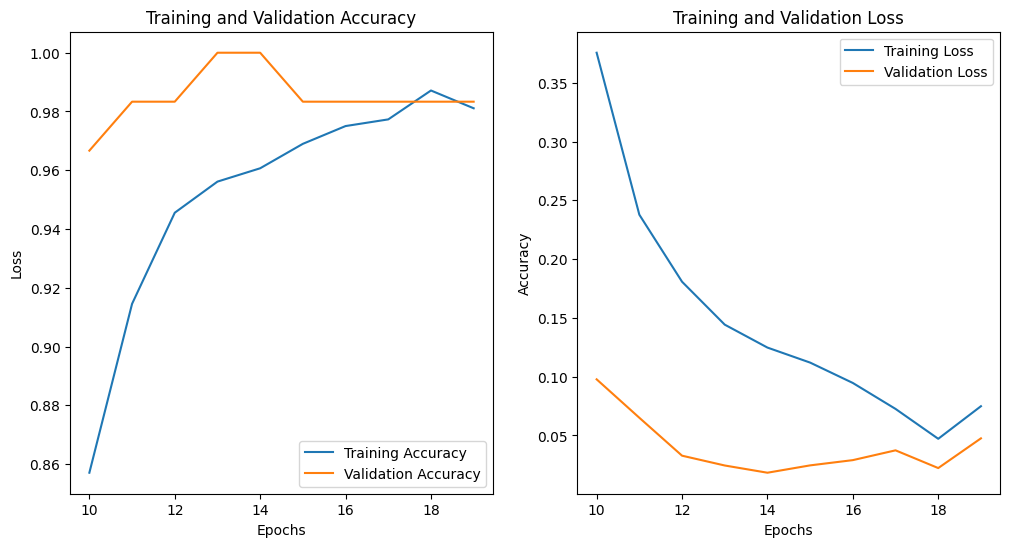

In [28]:
plot_training(history_finetune)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Classification Report:

              precision    recall  f1-score   support

     Healthy       0.98      0.94      0.96        50
     Powdery       0.96      0.96      0.96        50
        Rust       0.96      1.00      0.98        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



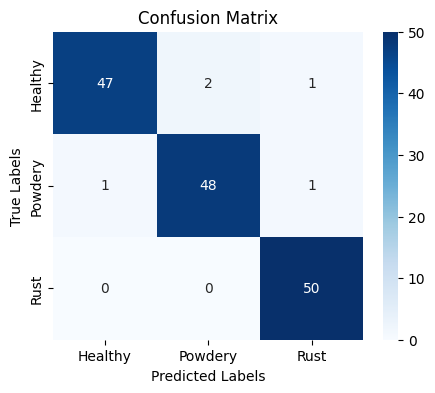

In [29]:
evaluate_model(vgg_model, test_generator)